In [1]:
import sys
from tqdm import tqdm
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['font.family'] = 'arial'
mpl.rcParams['font.size'] = 14
np.set_printoptions(threshold=sys.maxsize,
                    suppress=True)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split, Dataset, DataLoader
import torch.optim as optim

from gait_dataset import GaitDataset
from gait_model import GaitGRUModel

torch.manual_seed(114514)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(torch.__config__.show())
print(f'PyTorch is running on {device}')

PyTorch built with:
  - C++ Version: 199711
  - MSVC 193431937
  - Intel(R) Math Kernel Library Version 2020.0.2 Product Build 20200624 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 2019
  - LAPACK is enabled (usually provided by MKL)
  - CPU capability usage: AVX2
  - CUDA Runtime 11.8
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_61,code=sm_61;-gencode;arch=compute_70,code=sm_70;-gencode;arch=compute_75,code=sm_75;-gencode;arch=compute_80,code=sm_80;-gencode;arch=compute_86,code=sm_86;-gencode;arch=compute_90,code=sm_90;-gencode;arch=compute_37,code=compute_37
  - CuDNN 8.7
  - Magma 2.5.4
  - Build settings: BLAS_INFO=mkl, BUILD_TYPE=Release, CUDA_VERSION=11.8, CUDNN_VERSION=8.7.0, CXX_COMPILER=C:/cb/pytorch_1000000000000/work/tmp_bin/sccache-cl.exe, CXX_FLAGS=/DWIN32 /D_WINDOWS /GR /EH

# Data load

In [2]:
batch_size = 32

ds = torch.load('dataset/gait_m1.pt')

train_size = int(0.8 * len(ds))
test_size = len(ds) - train_size

train_ds, test_ds = random_split(ds, (train_size, test_size))
train_loader, test_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False), DataLoader(test_ds, batch_size=batch_size, shuffle=False)

# Hyperparameters

In [32]:
input_dim = 8
hidden_dim = 128
layer_dim = 1
output_dim = len(torch.unique(ds.labels)) # Number of classes
dropout_prob = 0

reduced_chnl = 4
kernel_size = 100
stride = 100

num_epochs = 100

# Training

In [33]:
print(ds.features.shape)
print(ds.labels.shape)

torch.Size([404, 8, 1500])
torch.Size([404])


In [34]:
model = GaitGRUModel(input_dim, hidden_dim, layer_dim, output_dim,
                     reduced_chnl, kernel_size, stride).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.002, weight_decay=0.01)

print(model)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

GaitGRUModel(
  (channel_weights): Linear(in_features=8, out_features=4, bias=True)
  (seq_reduction_conv): Conv1d(4, 4, kernel_size=(100,), stride=(100,), padding=(1,))
  (gru): GRU(4, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=13, bias=True)
  (softmax): LogSoftmax(dim=1)
)
54773


In [35]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for i, (features, labels) in enumerate(train_loader):
        features, labels = features.to(device).float(), labels.to(device).long()

        # print(features.shape)
        outputs = model(features)
        # print(outputs.shape)

        loss = criterion(outputs, labels.squeeze())
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_predictions / total_predictions
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Testing phase
    model.eval()
    test_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    with torch.no_grad():
        for features, labels in test_loader:
            features, labels = features.to(device).float(), labels.to(device).long()
            outputs = model(features)

            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
    
    test_loss /= len(test_loader)
    test_accuracy = correct_predictions / total_predictions
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    if (epoch + 1) % 20 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, \
            Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

 22%|██▏       | 22/100 [00:01<00:04, 16.79it/s]

Epoch [20/100], Train Loss: 1.5715, Train Accuracy: 0.4056,             Test Loss: 1.7613, Test Accuracy: 0.3827


 42%|████▏     | 42/100 [00:02<00:03, 17.09it/s]

Epoch [40/100], Train Loss: 1.2253, Train Accuracy: 0.4427,             Test Loss: 1.2456, Test Accuracy: 0.4938


 62%|██████▏   | 62/100 [00:03<00:02, 13.00it/s]

Epoch [60/100], Train Loss: 0.8649, Train Accuracy: 0.6563,             Test Loss: 1.0313, Test Accuracy: 0.6667


 82%|████████▏ | 82/100 [00:05<00:01, 16.26it/s]

Epoch [80/100], Train Loss: 0.7708, Train Accuracy: 0.6966,             Test Loss: 0.9622, Test Accuracy: 0.6914


100%|██████████| 100/100 [00:06<00:00, 16.09it/s]

Epoch [100/100], Train Loss: 0.6702, Train Accuracy: 0.7492,             Test Loss: 0.9837, Test Accuracy: 0.6543


Text(0.5, 0, 'Epoch')

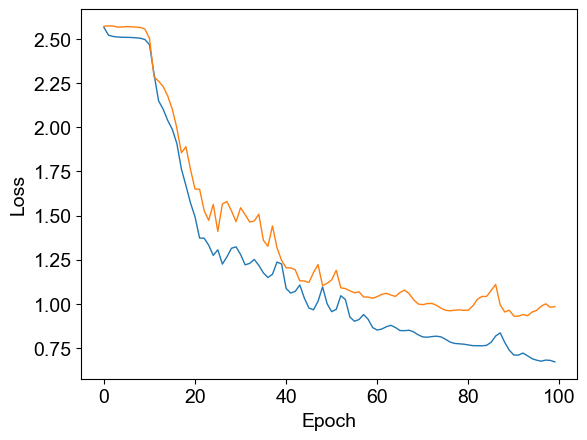

In [36]:
plt.plot(train_losses)
plt.plot(test_losses)
plt.ylabel('Loss')
plt.xlabel('Epoch')

Text(0.5, 0, 'Epoch')

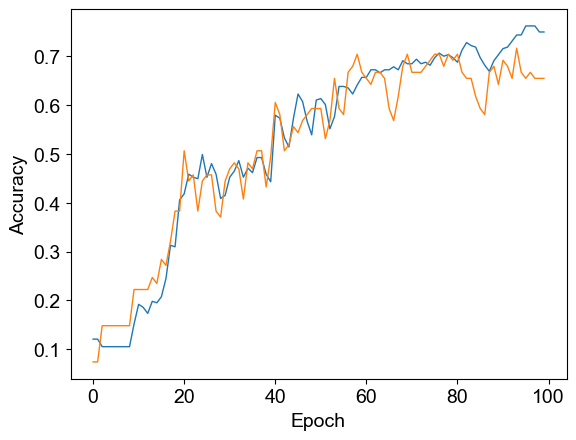

In [37]:
plt.plot(train_accuracies)
plt.plot(test_accuracies)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

In [38]:
print("Model's state_dict: ")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict: 
channel_weights.weight 	 torch.Size([4, 8])
channel_weights.bias 	 torch.Size([4])
seq_reduction_conv.weight 	 torch.Size([4, 4, 100])
seq_reduction_conv.bias 	 torch.Size([4])
gru.weight_ih_l0 	 torch.Size([384, 4])
gru.weight_hh_l0 	 torch.Size([384, 128])
gru.bias_ih_l0 	 torch.Size([384])
gru.bias_hh_l0 	 torch.Size([384])
fc.weight 	 torch.Size([13, 128])
fc.bias 	 torch.Size([13])
Optimizer's state_dict:
state 	 {0: {'step': tensor(1100.), 'exp_avg': tensor([[-0.0006,  0.0096,  0.0127,  0.0053, -0.0017, -0.0189, -0.0104, -0.0232],
        [-0.0011,  0.0019,  0.0034,  0.0044, -0.0099, -0.0086, -0.0062, -0.0065],
        [ 0.0108, -0.0256, -0.0332, -0.0186,  0.0101,  0.0522,  0.0247,  0.0620],
        [ 0.0114, -0.0097, -0.0286, -0.0239,  0.0303,  0.0402,  0.0290,  0.0537]],
       device='cuda:0'), 'exp_avg_sq': tensor([[0.0001, 0.0004, 0.0004, 0.0001, 0.0007, 0.0005, 0.0003, 0.0015],
        [0.0002, 0.0009, 0.0009, 0.0003, 0.0005, 0.0003, 0.0002, 0.0009],
  

In [39]:
torch.save(model.state_dict(), 'model_m1.pt')

___
# Visualization


In [40]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_pred = []
y_true = []

model.eval()
with torch.no_grad():
    for features, labels in test_loader:
        features = features.to(device).float()
        labels = labels.to(device)
        outputs = model(features)
        # print(outputs)
        outputs = torch.argmax(outputs, dim=1).cpu().numpy()

        y_pred.extend(outputs)
        y_true.extend(labels.cpu().numpy())

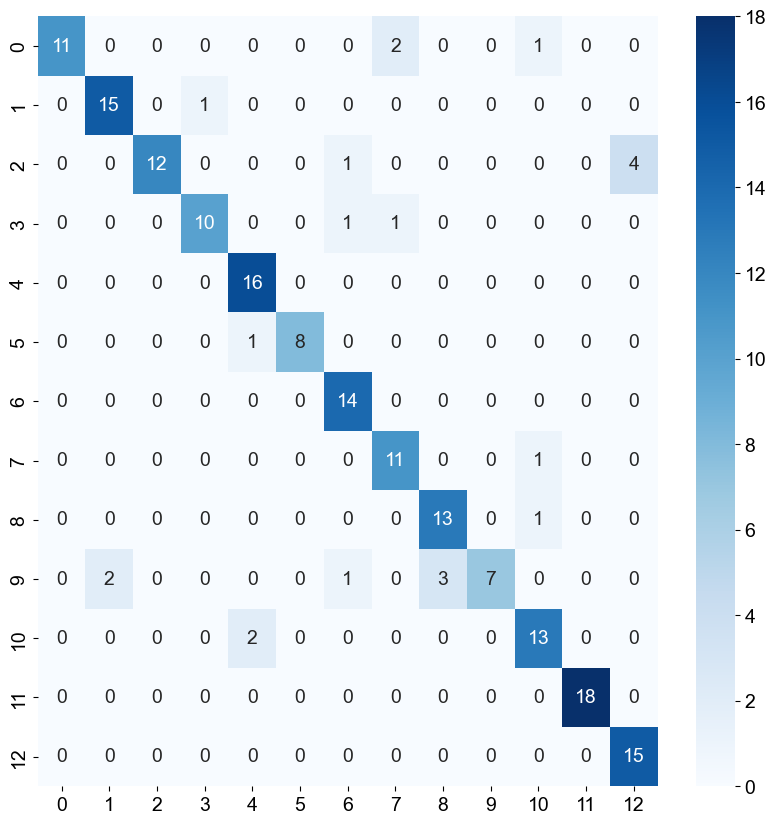

In [23]:
plt.figure(figsize=(10, 10))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.show()

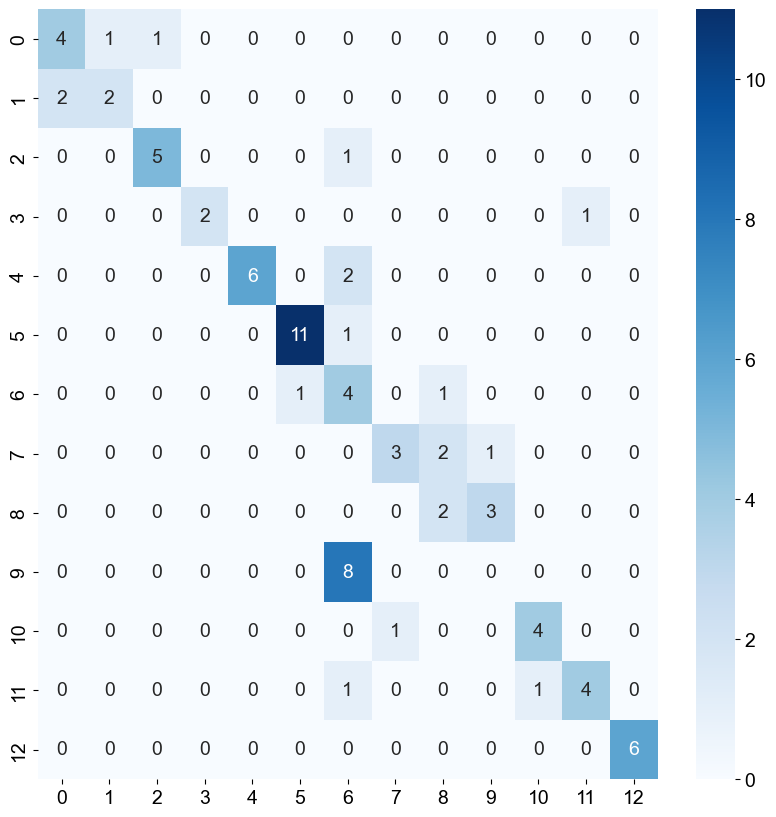

In [41]:
plt.figure(figsize=(10, 10))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.show()